In [137]:
import os, sys
import numpy as np
from numpy.random import default_rng
import torch as th
from torch import nn
from sklearn import datasets, tree
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [596]:
from src.plotting import plot_roc, plot_losses, compare_histograms
from src.modeling import NumericEmbedding, train, decision_tree_encoding, FeedForwardMLPResidual
from src.toy_data_generation import Distribution, ToyDataGenerator

In [5]:
gen = ToyDataGenerator()
gen.add_normal(1, 1)
gen.add_gamma(1, 1)
gen.add_gamma(1, 2)
gen.add_lognormal(1, 1)

In [6]:
X = gen.generate(5000)

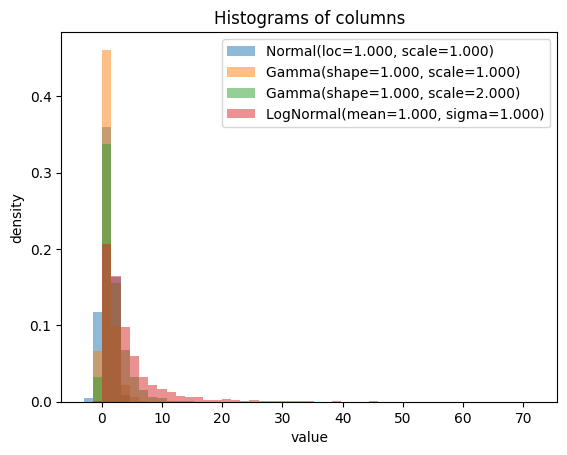

In [7]:
fig, ax = plt.subplots()
bins = np.linspace(X.min(), X.max(), 50)
kwargs = dict(alpha=0.5, density=True)
for idx in range(X.shape[1]):
    _, _, _ = ax.hist(X[:,idx], bins=bins, label=gen.distributions[idx], **kwargs)

ax.set(xlabel='value', ylabel='density', title='Histograms of columns')
_ = ax.legend()

## Make ML classification datasets
- This shows it well:  
  - `c1_generator.add_lognormal(1, 1)`, `c2_generator.add_lognormal(1, 2)`
  

In [8]:
c1_generator = ToyDataGenerator()
c2_generator = ToyDataGenerator()

# normal - different mean, same std
# c1_generator.add_normal(1, 1)
# c2_generator.add_normal(2, 1)

# normal - same mean, different std
# c1_generator.add_normal(1, 1)
# c2_generator.add_normal(1, 2)

# normal - different mean, different std
c1_generator.add_normal(1, 1)
c2_generator.add_normal(2, 2)

# log-normal - same mean, different std
# c1_generator.add_lognormal(1, 1)
# c2_generator.add_lognormal(1, 2)

# log-normal - different mean, same std
# c1_generator.add_lognormal(1, 3)
# c2_generator.add_lognormal(2, 3)

# gamma - double sided
# c1_generator.add_gamma(5, 3)
# c2_generator.add_gamma(2, 8)

In [207]:
N_1, N_2 = 10000, 10000
X_1 = c1_generator.generate(N_1)
X_2 = c2_generator.generate(N_2)
idx = default_rng().permutation(np.arange(N_1+N_2))

X = np.vstack([X_1, X_2])[idx,:]
y = np.concatenate([np.zeros(N_1), np.ones(N_2)])[idx]

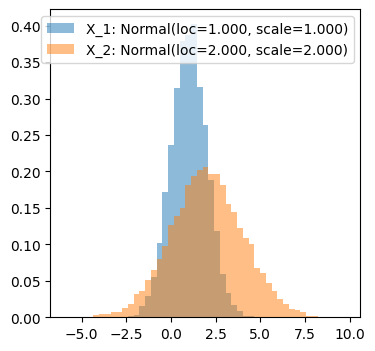

In [208]:
compare_histograms(X_1, X_2, c1_generator.distributions, c2_generator.distributions)

In [209]:
X = th.tensor(X).float()
y = th.tensor(y)

In [210]:
N_train = int(X.shape[0]*0.7)
N_val = int(X.shape[0]*0.15)
X_train = X[:N_train,:]
y_train = y[:N_train].float()
X_val = X[N_train:N_train+N_val,:]
y_val = y[N_train:N_train+N_val].float()
X_test = X[N_train+N_val:,:]
y_test = y[N_train+N_val:].float()

In [211]:
if X.shape[1] >= 2:
    pca = PCA(n_components=2)
    pca.fit(X)
    fig, ax = plt.subplots()
    ax.scatter(pca.transform(X)[:,0], pca.transform(X)[:,1], c=y, s=1)
    _ = ax.grid()

## Random Forest baseline

In [212]:
from sklearn.ensemble import RandomForestClassifier

In [213]:
# clf_rf = RandomForestClassifier(max_leaf_nodes=10, n_estimators=10)
clf_rf = RandomForestClassifier(n_estimators=300, max_depth=8)

In [214]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=300)

In [215]:
y_hat_rf = clf_rf.predict_proba(X_test)[:,1]

## Neural networks

In [216]:
N_epochs = 5000
es_criteria = 100

### Raw features

In [217]:
model_raw = nn.Linear(X.shape[1], 1)

In [218]:
train_losses, test_losses, y_hat_raw = train(
    model_raw, X_train, y_train, X_val, y_val, X_test, N_epochs, stop_criteria=es_criteria
)

Early stopping at epoch 115 with valid acc 0.660


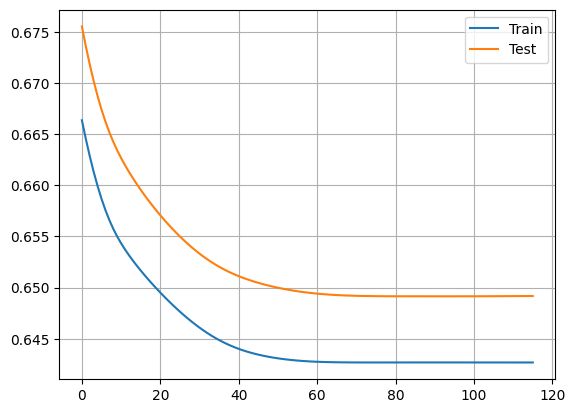

In [219]:
plot_losses(train_losses, test_losses)

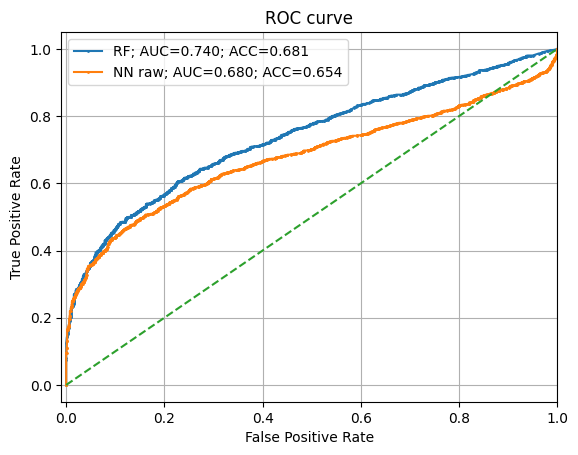

In [220]:
plot_roc(y_test,[y_hat_rf, y_hat_raw], ['RF', 'NN raw'])

### Standard scaling methods

In [221]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer

#### all StandardScalar

In [222]:
ss = StandardScaler()
X_train_ss = th.tensor(ss.fit_transform(X_train)).float()
X_val_ss = th.tensor(ss.transform(X_val)).float()
X_test_ss = th.tensor(ss.transform(X_test)).float()

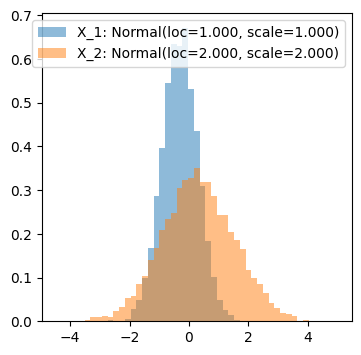

In [223]:
compare_histograms(X_train_ss[y_train==0], X_train_ss[y_train==1], c1_generator.distributions, c2_generator.distributions)

In [224]:
model_ss = nn.Linear(X.shape[1], 1)

In [225]:
train_losses_ss, test_losses_ss, y_hat_ss = train(
    model_ss, X_train_ss, y_train, X_val_ss, y_val, X_test_ss, 
    N_epochs, stop_criteria=es_criteria
)

Early stopping at epoch 102 with valid acc 0.498


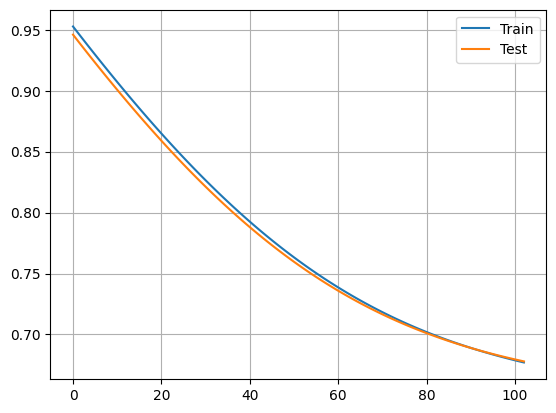

In [226]:
plot_losses(train_losses_ss, test_losses_ss)

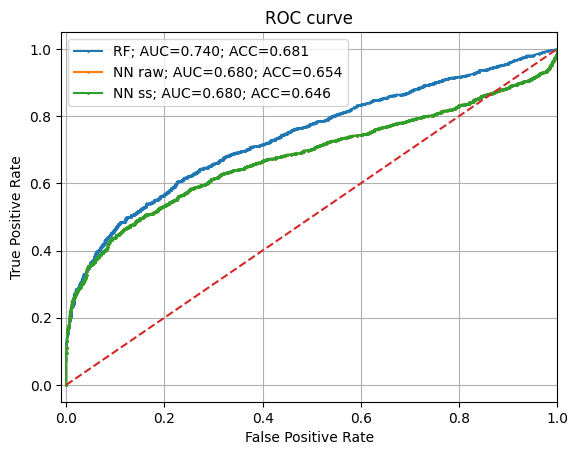

In [227]:
plot_roc(y_test,[y_hat_rf, y_hat_raw, y_hat_ss], ['RF', 'NN raw', 'NN ss'])

#### all QuantileTransformer

In [228]:
qt = QuantileTransformer(output_distribution='normal')
X_train_qt = th.tensor(qt.fit_transform(X_train)).float()
X_val_qt = th.tensor(qt.transform(X_val)).float()
X_test_qt = th.tensor(qt.transform(X_test)).float()

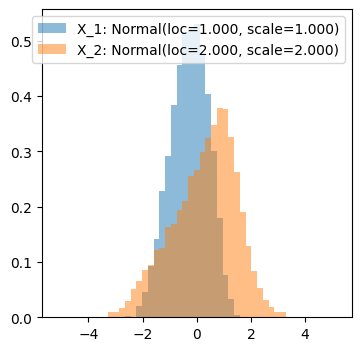

In [229]:
compare_histograms(X_train_qt[y_train==0], X_train_qt[y_train==1], c1_generator.distributions, c2_generator.distributions)

In [230]:
model_qt = nn.Linear(X.shape[1], 1)

In [231]:
train_losses_qt, test_losses_qt, y_hat_qt = train(
    model_qt, X_train_qt, y_train, X_val_qt, y_val, X_test_qt, 
    N_epochs, stop_criteria=es_criteria
)

Early stopping at epoch 128 with valid acc 0.660


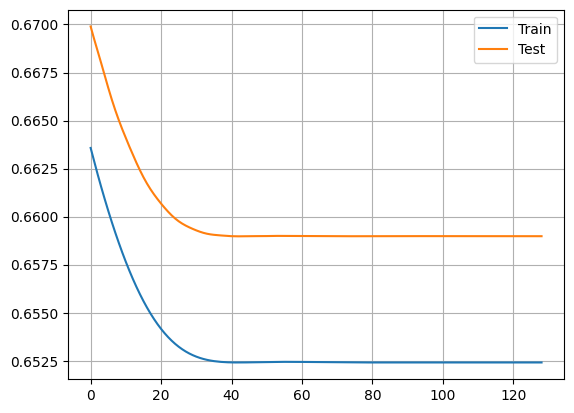

In [232]:
plot_losses(train_losses_qt, test_losses_qt)

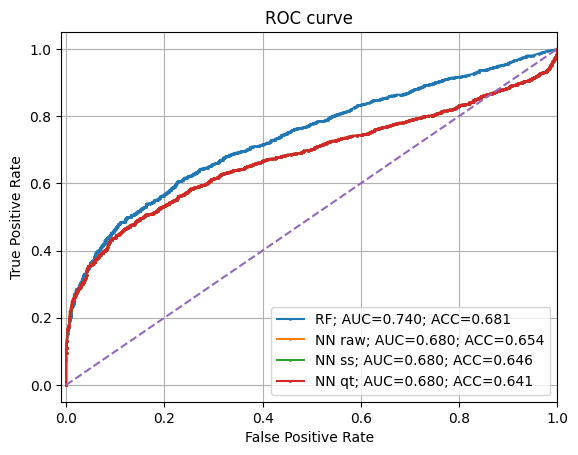

In [233]:
plot_roc(y_test,[y_hat_rf, y_hat_raw, y_hat_ss, y_hat_qt], ['RF', 'NN raw', 'NN ss', 'NN qt'])

#### AutoGluon logic
i.e., QuantileTransformer if skew > 0.99

In [234]:
from scipy.stats import skew

In [235]:
skew_mask = np.array([skew(X_train[:,idx])>0.99 for idx in range(X_train.shape[1])])

In [236]:
skew_mask.sum()

0

 No skewed distributions, so same as StandardScaler

#### Bucketize
Use equally-spaced bins

In [237]:
from sklearn.preprocessing import OneHotEncoder

In [238]:
X_train_bus = list()
X_val_bus = list()
X_test_bus = list()
for idx in range(X_train.shape[1]):
    bins = np.linspace(X_train[:,idx].min(), X_train[:,idx].max(), 10)
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    ohe.fit(np.digitize(X_train[:,idx], bins).reshape(-1, 1))
    X_train_bus.append(th.tensor(ohe.transform(np.digitize(X_train[:,idx], bins).reshape(-1, 1))).float())
    X_val_bus.append(th.tensor(ohe.transform(np.digitize(X_val[:,idx], bins).reshape(-1, 1))).float())
    X_test_bus.append(th.tensor(ohe.transform(np.digitize(X_test[:,idx], bins).reshape(-1, 1))).float())
X_train_bu = th.cat(X_train_bus, dim=1)
X_val_bu = th.cat(X_val_bus, dim=1)
X_test_bu = th.cat(X_test_bus, dim=1)

In [239]:
bins

array([-5.96010256, -4.2073467 , -2.45459085, -0.701835  ,  1.05092086,
        2.80367671,  4.55643257,  6.30918842,  8.06194427,  9.81470013])

In [240]:
X_train_bu.sum(dim=0).int().numpy()

array([   4,   91,  824, 4979, 5510, 1851,  630,  105,    5,    1],
      dtype=int32)

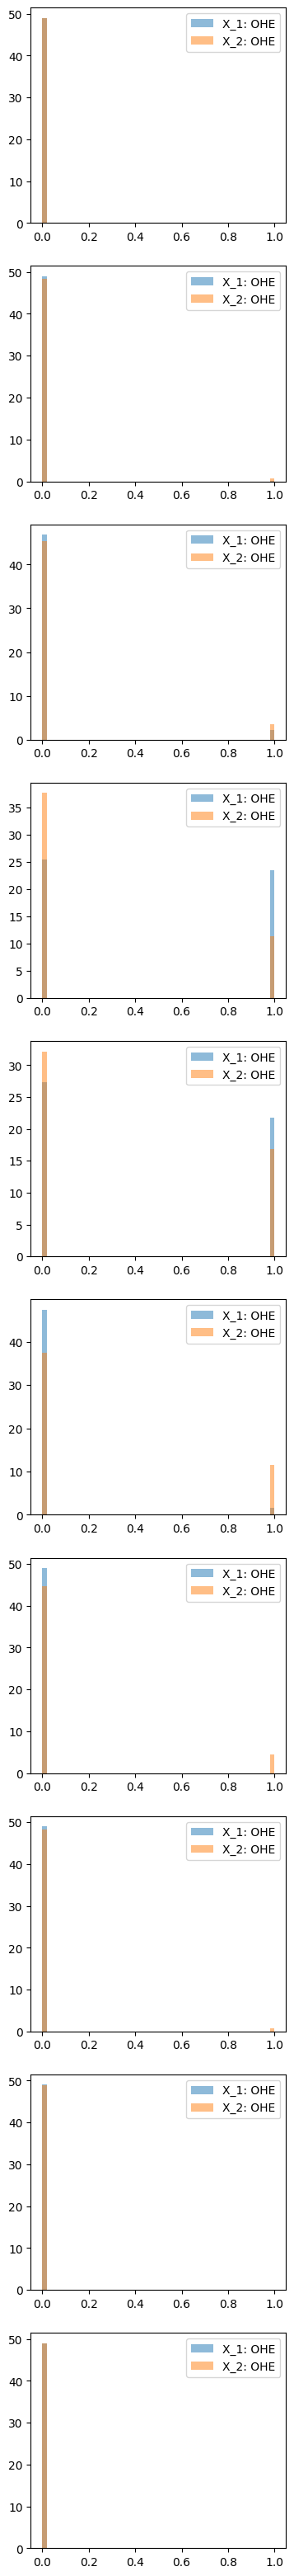

In [241]:
compare_histograms(X_train_bu[y_train==0], X_train_bu[y_train==1], ['OHE']*10, ['OHE']*10)

In [242]:
X_train.shape, X_train_bu.shape

(torch.Size([14000, 1]), torch.Size([14000, 10]))

In [243]:
model_bu = nn.Linear(X_train_bu.shape[1], 1)

In [244]:
train_losses_bu, test_losses_bu, y_hat_bu = train(
    model_bu, X_train_bu, y_train, X_val_bu, y_val, X_test_bu, 
    N_epochs, stop_criteria=es_criteria
)

Early stopping at epoch 145 with valid acc 0.661


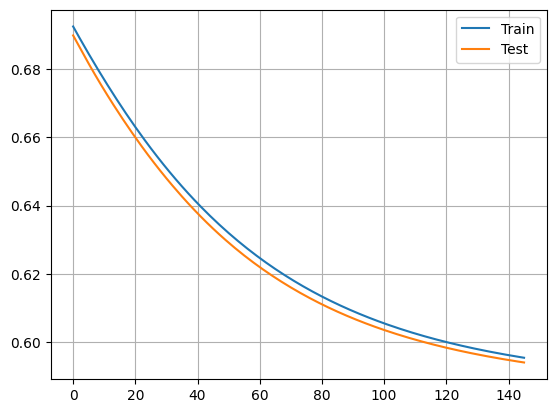

In [245]:
plot_losses(train_losses_bu, test_losses_bu)

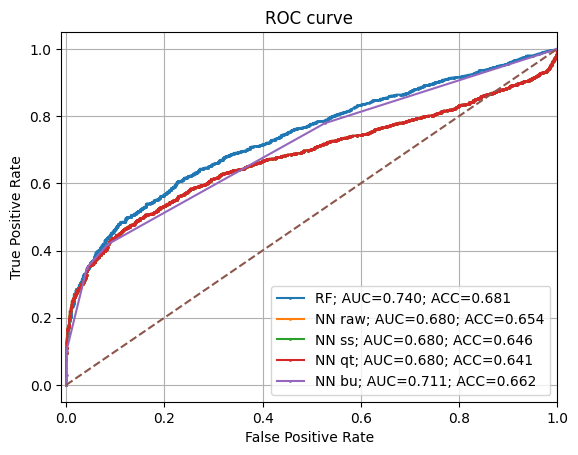

In [246]:
plot_roc(
    y_test,
    [y_hat_rf, y_hat_raw, y_hat_ss, y_hat_qt, y_hat_bu], 
    ['RF', 'NN raw', 'NN ss', 'NN qt', 'NN bu']
)

## Map numeric to decision tree leafs

In [247]:
Xs_dt, decision_trees, leaf_encoders = decision_tree_encoding(
    {'train': X_train, 'valid': X_val, 'test': X_test}, 
    {'train': y_train, 'valid': y_val, 'test': y_test}, 
    min_impurity_decrease=1e-4
)#, max_splits=20)

In [407]:
n_uniques = (Xs_dt['train'].max(dim=0)[0]+1).numpy()
n_uniques

array([87])

In [408]:
X_t_train = Xs_dt['train']
X_t_val = Xs_dt['valid']
X_t_test = Xs_dt['test']

In [409]:
n_uniques = (X_t_train.max(dim=0)[0]+1).numpy()
n_uniques

array([87])

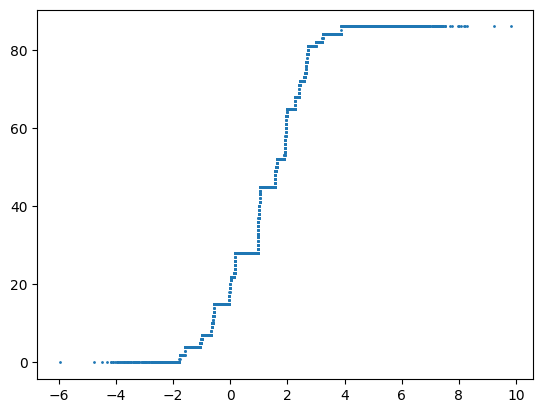

In [410]:
fig, ax = plt.subplots()
ax.scatter(X_train, X_t_train, s=1)

In [597]:
embed_dim = 1
hidden_dim = 32

# model = nn.Sequential(NumericEmbedding(n_uniques, 1, 'concat'), nn.Linear(len(topN), 1))
# model_dt = nn.Sequential(NumericEmbedding(n_uniques, embed_dim, 'concat'), nn.Linear(n_uniques.shape[0]*embed_dim, 1))
# model = nn.Sequential(NumericEmbedding(n_uniques, 8, 'mean'), nn.Linear(8, 1))

model_dt = nn.Sequential(
    NumericEmbedding(n_uniques, embed_dim, 'concat'),
#     FeedForwardMLPResidual(
#         d_model=n_uniques.shape[0]*embed_dim, dim_feedforward=hidden_dim, dropout=0, norm_first=True,
#     ),
    nn.Linear(n_uniques.shape[0]*embed_dim, 1),
)

In [598]:
model_dt

Sequential(
  (0): NumericEmbedding(
    (embeds): ModuleList(
      (0): Embedding(87, 1)
    )
  )
  (1): Linear(in_features=1, out_features=1, bias=True)
)

In [599]:
sum([p.numel() for p in model_dt.parameters()])

89

In [600]:
train_losses_dt, test_losses_dt, y_hat_dt = train(
    model_dt, X_t_train, y_train, X_t_val, y_val, X_t_test,
    N_epochs, stop_criteria=es_criteria,
#     l1_lambda=1e-3, 
    embed_smooth_lambda=1e-3,
)

Early stopping at epoch 414 with valid acc 0.687


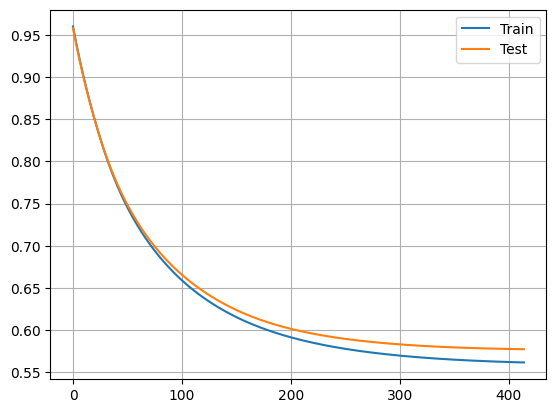

In [601]:
plot_losses(train_losses_dt, test_losses_dt)

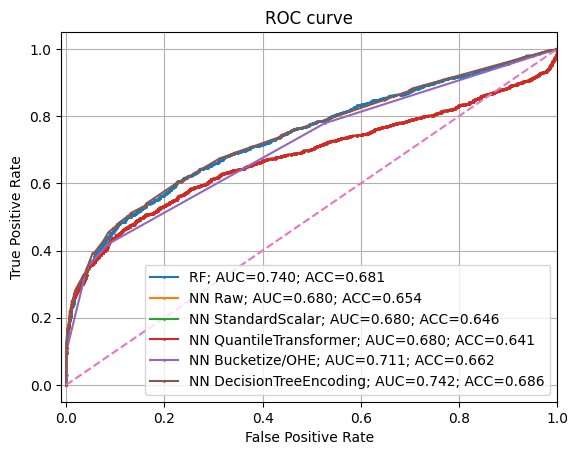

In [602]:
plot_roc(
    y_test,
    [y_hat_rf, y_hat_raw, y_hat_ss, y_hat_qt, y_hat_bu, y_hat_dt],
    ['RF', 'NN Raw', 'NN StandardScalar', 'NN QuantileTransformer', 'NN Bucketize/OHE', 'NN DecisionTreeEncoding'],
    # x_max=0.1,
)

#### Visualize embeddings

In [603]:
with th.no_grad():
    X_embed_train = model_dt[0](X_t_train).numpy()
    X_embed_val = model_dt[0](X_t_val).numpy()
    X_embed_test = model_dt[0](X_t_test).numpy()

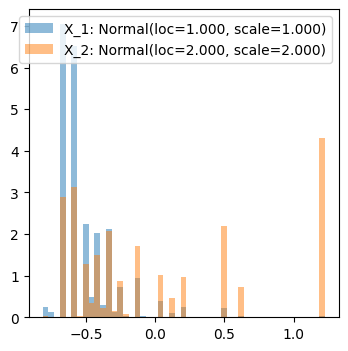

In [604]:
compare_histograms(
    X_embed_train[y_train==0], X_embed_train[y_train==1], c1_generator.distributions, c2_generator.distributions
)

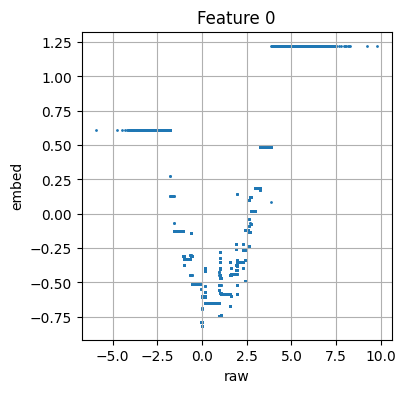

In [605]:
#Raw vs learned
fig, axs = plt.subplots(X_embed_train.shape[1], 1, figsize=(4*X_embed_train.shape[1], 4))
if not hasattr(axs, '__iter__'):
    axs = [axs]

for idx, ax in enumerate(axs):
    _ = ax.scatter(X_train[:, idx], X_embed_train[:, idx], s=1)
    ax.set(xlabel='raw', ylabel='embed', title=f'Feature {idx}')
    _ = ax.grid()

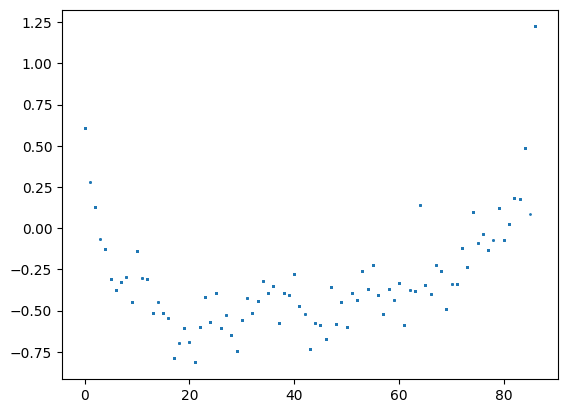

In [606]:
fig, ax = plt.subplots()
# ax.scatter(X_train, X_t_train, s=1)
# ax.scatter(X_train, X_embed_train, s=1)
# ax.scatter(X_embed_train, X_train, s=1)
ax.scatter(X_t_train, X_embed_train, s=1)

In [607]:
d = model_dt[0].embeds[0].weight.data

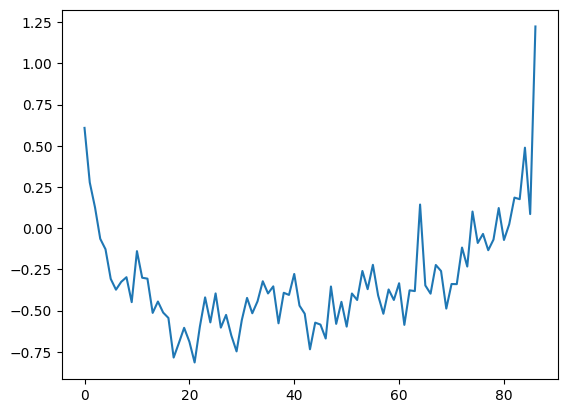

In [608]:
fig, ax = plt.subplots()
ax.plot(d)

In [609]:
# X[1:,:]-X[:-1,:]
((d[1:,:]-d[:-1,:])**2).mean()

tensor(0.0469)

In [610]:
if X_embed_train.shape[1] >= 2:
    pca = PCA(n_components=2)
    pca.fit(X_embed_train)
    fig, ax = plt.subplots()
    ax.scatter(pca.transform(X_embed_test)[:,0], pca.transform(X_embed_test)[:,1], c=y_test, s=1)
    _ = ax.grid()

## PLE
How do I extract the bins from each tree?
Simple way:  take the max/min of the training data, and then clamp to max(0, leaf_max-val), min()

In [611]:
import pandas as pd

In [612]:
x_min_max_map = pd.DataFrame(
    {'x': X_train.numpy().flatten(), 'c': Xs_dt['train'].numpy().flatten()}
).groupby('c')['x'].agg(['min', 'max']).to_dict(orient='index')

In [613]:
def ple_map(x, c, x_min_max_map):
    min_ = min(x, x_min_max_map[c]['min'])
    max_ = max(x, x_min_max_map[c]['max'])
    if x - min_ == 0:
        return 0
    else:
        return (x - min_)/(max_ - min_)

In [614]:
Xs_dt_resid = dict()
for X_, type_ in zip([X_train, X_val, X_test], ['train', 'valid', 'test']):
    vals = pd.DataFrame(
        {'x': X_.numpy().flatten(), 'c': Xs_dt[type_].numpy().flatten()}
    ).apply(
        lambda x: ple_map(x['x'], x['c'], x_min_max_map), 
        axis=1
    ).values
    Xs_dt_resid[type_] = th.tensor(vals-0.5).float().reshape((-1,1))

In [615]:
Xs_residual = dict()
for type_ in ['train', 'valid', 'test']:
    Xs_residual[type_] = th.cat([Xs_dt[type_].float(), Xs_dt_resid[type_].float()], dim=1)

In [630]:
embed_dim = 1
hidden_dim = 512

model_dt_resid = nn.Sequential(
    NumericEmbedding(n_uniques, embed_dim, 'concat', residual_method='concat'),
    FeedForwardMLPResidual(
        d_model=n_uniques.shape[0]*embed_dim+1, dim_feedforward=hidden_dim, dropout=0.5, norm_first=True,
    ),
    FeedForwardMLPResidual(
        d_model=n_uniques.shape[0]*embed_dim+1, dim_feedforward=hidden_dim, dropout=0.5, norm_first=True,
    ),
#     FeedForwardMLPResidual(
#         d_model=n_uniques.shape[0]*embed_dim+1, dim_feedforward=hidden_dim, dropout=0.5, norm_first=True,
#     ),
    nn.Linear(n_uniques.shape[0]*embed_dim+1, 1),
)

In [631]:
sum([p.numel() for p in model_dt_resid.parameters()])

5222

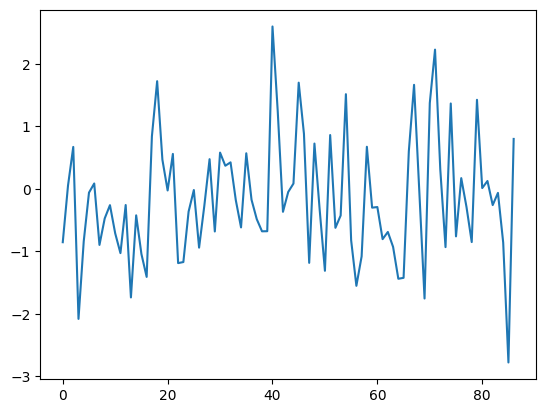

In [632]:
fig, ax = plt.subplots()
ax.plot(model_dt_resid[0].embeds[0].weight.data)

In [633]:
train_losses_resid, test_losses_resid, y_hat_resid = train(
    model_dt_resid, Xs_residual['train'], y_train, Xs_residual['valid'], y_val, Xs_residual['test'],
    N_epochs, lr=1e-3,
    stop_criteria=N_epochs, #es_criteria,
#     l1_lambda=1e-3,
    embed_smooth_lambda=1e-2,
)

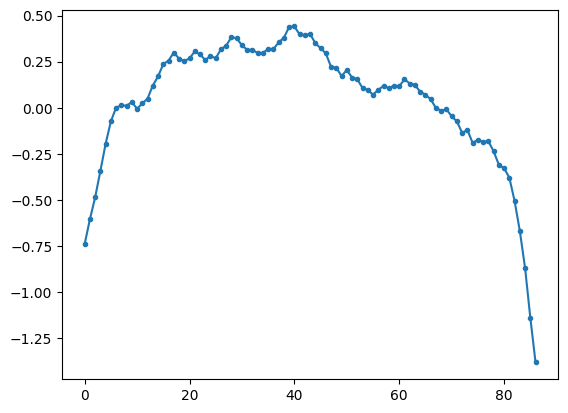

In [634]:
fig, ax = plt.subplots()
ax.plot(model_dt_resid[0].embeds[0].weight.data, marker='.')

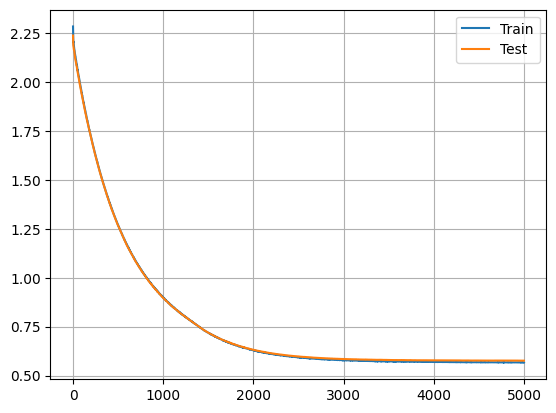

In [635]:
plot_losses(train_losses_resid, test_losses_resid)

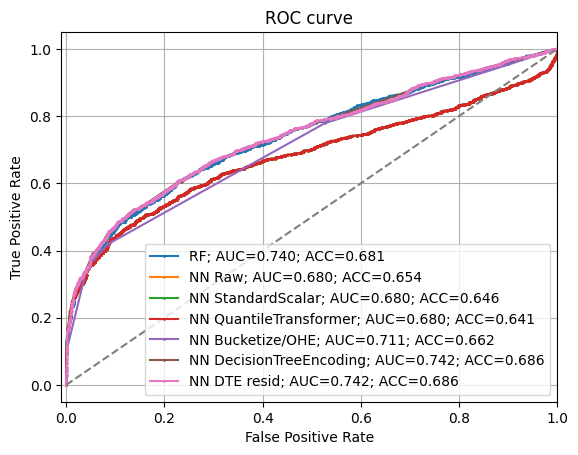

In [636]:
plot_roc(
    y_test,
    [y_hat_rf, y_hat_raw, y_hat_ss, y_hat_qt, y_hat_bu, y_hat_dt, y_hat_resid],
    ['RF', 'NN Raw', 'NN StandardScalar', 'NN QuantileTransformer', 'NN Bucketize/OHE', 'NN DecisionTreeEncoding', 'NN DTE resid'],
    # x_max=0.1,
)

#### Visualize embeddings

In [637]:
with th.no_grad():
    X_embed_train_r = model_dt_resid[0](Xs_residual['train']).numpy()
    X_embed_val_r = model_dt_resid[0](Xs_residual['valid']).numpy()
    X_embed_test_r = model_dt_resid[0](Xs_residual['test']).numpy()

IndexError: list index out of range

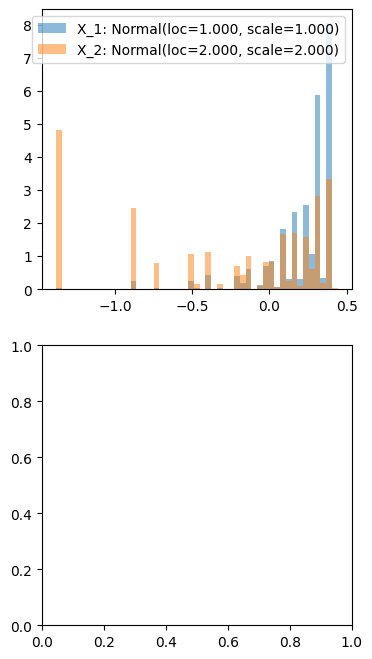

In [638]:
compare_histograms(
    X_embed_train_r[y_train==0], X_embed_train_r[y_train==1], c1_generator.distributions, c2_generator.distributions
)

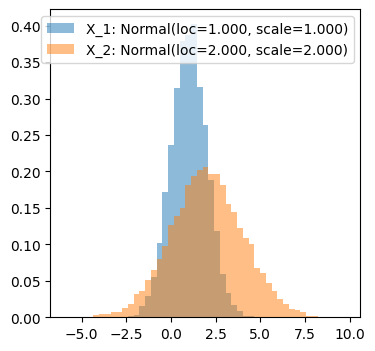

In [639]:
compare_histograms(X_1, X_2, c1_generator.distributions, c2_generator.distributions)

IndexError: index 1 is out of bounds for dimension 1 with size 1

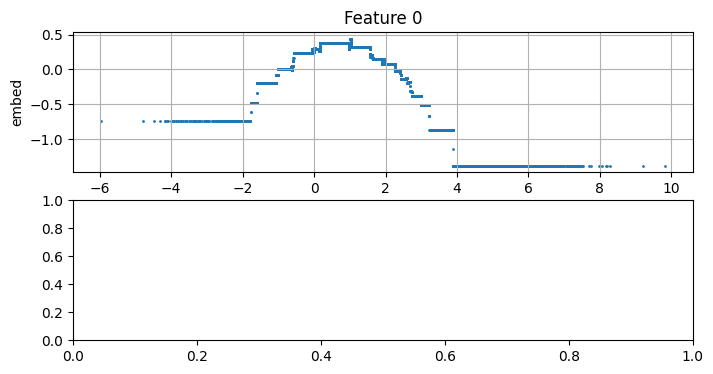

In [640]:
#Raw vs learned
fig, axs = plt.subplots(X_embed_train_r.shape[1], 1, figsize=(4*X_embed_train_r.shape[1], 4))
if not hasattr(axs, '__iter__'):
    axs = [axs]

for idx, ax in enumerate(axs):
    _ = ax.scatter(X_train[:, idx], X_embed_train_r[:, idx], s=1)
    ax.set(xlabel='raw', ylabel='embed', title=f'Feature {idx}')
    _ = ax.grid()

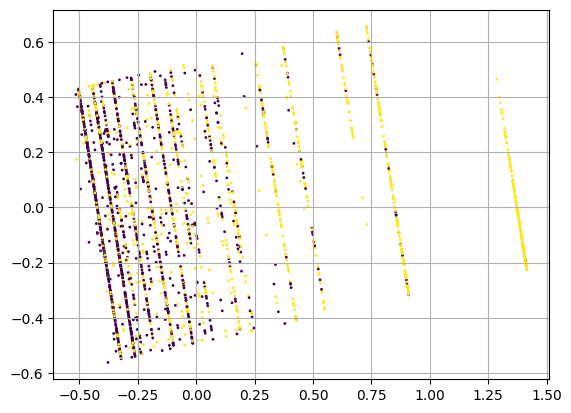

In [641]:
if X_embed_train_r.shape[1] >= 2:
    pca = PCA(n_components=2)
    pca.fit(X_embed_train_r)
    fig, ax = plt.subplots()
    ax.scatter(pca.transform(X_embed_test_r)[:,0], pca.transform(X_embed_test_r)[:,1], c=y_test, s=1)
    _ = ax.grid()